# DA_assignment4
group member: Jiayu Chen(jic117), Huan Chen(huc48), Chang Tian(cht97)

File house-votes-84.txt (attached) contains 435 records of UnitedStates representatives.  Each record shows how the representative voted on each of 16 different issues (columns in the file).

Based on the voting records, guess the party affiliation of the representative (there are only two parties represented in the United States Congress: Democratic and Republican).

Your tasks:

1) Create a classification model of your choice (naive Bayes, logistic regression, Bayesian network, neural networks, etc.)

2) Find overall classification accuracy

3) Report sensitivity and specificity for each of the two parties

4) Measure positive and negative predictive value for each of the two parties

5) Plot ROC curve of your model

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

Please use the five-fold cross-validation method in your tests.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

In [2]:
DataHouseVotes = pd.read_csv('house-votes-84.csv')
DataHouseVotes.head()

,Party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,nti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_sa
0,republican,n,y,n,y,y,y,n,n,n,y,w,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,w
2,democrat,w,y,y,w,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,w,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,w,y,y,y,y


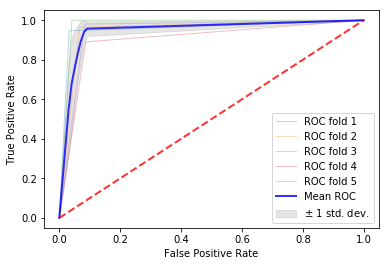

In [13]:
df=DataHouseVotes
df.replace('n',0, inplace=True)
df.replace('y',1, inplace=True)
df.replace('w', -1,inplace=True)
df.replace('republican', 0, inplace=True)
df.replace('democrat', 1, inplace=True)
X_features=df.iloc[:, range(1,17)] # dataframe get specify columns
Y_target=df.iloc[:, 0]

LogRegModel=LogisticRegression()
kf = KFold(n_splits=5, random_state=1, shuffle=True)
accuracy=0
sum_sen_de=0; sum_spe_de=0; sum_PPV_de=0; sum_NPV_de=0;
sum_sen_re=0; sum_spe_re=0; sum_PPV_re=0; sum_NPV_re=0;

tprs = []
mean_fpr = np.linspace(0, 1, 100)
i=0
for train_index, test_index in kf.split(X_features):
    i+=1
    train=train_index.tolist()
    test=test_index.tolist()
    X_train, X_test = X_features.iloc[train], X_features.iloc[test]
    Y_train, Y_test = Y_target.iloc[train_index], Y_target.iloc[test_index]
    fitted_model=LogRegModel.fit(X_train, Y_train)
    pre_y=LogRegModel.predict(X_test)
    accuracy += LogRegModel.score(X_test, Y_test)
    sen_de, spe_de, PPV_de, NPV_de = cal_sensitivity_specificity(Y_test, pre_y, 1, 0)
    sum_sen_de+=sen_de; sum_spe_de+=spe_de; sum_PPV_de+=PPV_de; sum_NPV_de+=NPV_de;
    sen_re, spe_re, PPV_re, NPV_re = cal_sensitivity_specificity(Y_test, pre_y, 0, 1)
    sum_sen_re+=sen_re; sum_spe_re+=spe_re; sum_PPV_re+=PPV_re; sum_NPV_re+=NPV_re;
    # draw ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, pre_y)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d' % (i))

# 5)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC',lw=2, alpha=.8)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend()
plt.show()

In [ ]:
def cal_sensitivity_specificity(Y_test, pre_y, party1, party2):
    TP=0;FP=0;FN=0;TN=0
    for i in range(Y_test.shape[0]):
        if(Y_test.iloc[i]==party1):
            if(pre_y[i]==party1):
                TP+=1
            elif(pre_y[i]==party2):
                FN+=1
        elif(Y_test.iloc[i]==party2):
            if(pre_y[i]==party1):
                FP+=1
            elif(pre_y[i]==party2):
                TN+=1
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    return sen, spe, PPV, NPV

In [14]:
# 1) & 2)
r_square_mean=accuracy/5
sen_de_mean = sum_sen_de/5
spe_de_mean = sum_spe_de/5
PPV_de_mean = sum_PPV_de/5
NPV_de_mean = sum_NPV_de/5

sen_re_mean = sum_sen_re/5
spe_re_mean = sum_spe_re/5
PPV_re_mean = sum_PPV_re/5
NPV_re_mean = sum_NPV_re/5

print('1) Create a classification model of logistic regression')
print('2) Find overall classification accuracy')
print('The accuracy score is:', r_square_mean)

# 3) & 4)
print('3) Report sensitivity and specificity for each of the two parties')    
print('sensitivity of democrat is:', sen_de_mean, '\nspecificity of democrat is:', spe_de_mean)
print('sensitivity of republican is:', sen_re_mean, '\nspecificity of republican is:', spe_re_mean)

print('\n4) Measure positive and negative predictive value for each of the two parties')
print('positive predictive value of democrat is:', PPV_de_mean, '\nnegative predictive value of democrat is:', NPV_de_mean)
print('positive predictive value of republican is:', PPV_re_mean, '\nnegative predictive value of republican is:', NPV_re_mean)

1) Create a classification model of logistic regression
2) Find overall classification accuracy
The accuracy score is: 0.947126436782
3) Report sensitivity and specificity for each of the two parties
sensitivity of democrat is: 0.9564716017986141 
specificity of democrat is: 0.9378237494156147
sensitivity of republican is: 0.9378237494156147 
specificity of republican is: 0.9564716017986141

4) Measure positive and negative predictive value for each of the two parties
positive predictive value of democrat is: 0.9614222391417414 
negative predictive value of democrat is: 0.9126024955436719
positive predictive value of republican is: 0.9126024955436719 
negative predictive value of republican is: 0.9614222391417414
